In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd drive/MyDrive/tcc_50

/content/drive/MyDrive/tcc_50


In [ ]:
import os
HOME = os.getcwd()
print(HOME)

/content/drive/MyDrive/tcc_50


In [ ]:
!git clone https://github.com/SkalskiP/yolov9.git
%cd yolov9
!pip install -r requirements.txt -q

Cloning into 'yolov9'...
remote: Enumerating objects: 325, done.
remote: Total 325 (delta 0), reused 0 (delta 0), pack-reused 325 (from 1)
Receiving objects: 100% (325/325), 2.25 MiB | 17.69 MiB/s, done.
Resolving deltas: 100% (162/162), done.
/content/drive/MyDrive/tcc_50/yolov9
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 47.6 MB/s eta 0:00:00


In [ ]:
!wget -P {HOME}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/yolov9-c.pt
!wget -P {HOME}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/yolov9-e.pt
!wget -P {HOME}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/gelan-c.pt
!wget -P {HOME}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/gelan-e.pt

In [ ]:
# Script responsável por descompactar pasta 'conjunto_treinamento.zip'

import zipfile

# Caminho para o arquivo
zip_file_path = '/content/drive/MyDrive/tcc_50/conjunto_treinamento.zip'

# Caminho para pasta onde será descompactado
extract_dir = '/content/drive/MyDrive/tcc_50/'

# Verifica se o arquivo existe
if os.path.exists(zip_file_path):
  try:
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
      zip_ref.extractall(extract_dir)
    print(f"Successfully unzipped {zip_file_path} to {extract_dir}")
  except zipfile.BadZipFile:
    print(f"Error: {zip_file_path} is not a valid zip file.")
  except Exception as e:
    print(f"An error occurred: {e}")
else:
  print(f"Error: {zip_file_path} does not exist.")

Successfully unzipped /content/drive/MyDrive/tcc_50/conjunto_treinamento.zip to /content/drive/MyDrive/tcc_50/


In [ ]:
# Script responsável por converter as coordenadas dos objetos para o formato aceito pelo YOLO

import os
from PIL import Image

def convert_to_yolo_format(image_path, txt_path, output_path):

    # Abre a imagem para obter suas dimensões
    image = Image.open(image_path)
    img_width, img_height = image.size

    # Lê o arquivo txt com as coordenadas
    with open(txt_path, 'r') as file:
        lines = file.readlines()

    yolo_annotations = []

    for line in lines:
        # Lê as coordenadas do objeto (x_min, y_min, x_max, y_max, class_id)
        class_id, x_min, y_min, x_max, y_max = map(int, line.strip().split(','))

        # Calcula o centro do bounding box
        x_center = (x_min + x_max) / 2.0
        y_center = (y_min + y_max) / 2.0

        # Calcula a largura e a altura do bounding box
        width = x_max - x_min
        height = y_max - y_min

        # Normaliza os valores
        x_center /= img_width
        y_center /= img_height
        width /= img_width
        height /= img_height

        # Adiciona a linha no formato YOLO
        yolo_annotations.append(f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}")

    # Salva o arquivo no formato YOLO
    with open(output_path, 'w') as out_file:
        out_file.write("\n".join(yolo_annotations))

# Caminhos para a pasta das imagens e arquivos de texto
image_folder = '/content/drive/MyDrive/tcc_50/conjunto_treinamento'
txt_folder = '/content/drive/MyDrive/tcc_50/conjunto_treinamento'

# Caminho para a pasta de saída
output_folder = '/content/drive/MyDrive/tcc_50/conjunto_treinamento'

os.makedirs(output_folder, exist_ok=True)

for filename in os.listdir(image_folder):
    if filename.endswith('.jpg') or filename.endswith('.png'):
        image_path = os.path.join(image_folder, filename)
        txt_path = os.path.join(txt_folder, filename.replace('.jpg', '.txt').replace('.png', '.txt'))
        output_path = os.path.join(output_folder, filename.replace('.jpg', '.txt').replace('.png', '.txt'))

        convert_to_yolo_format(image_path, txt_path, output_path)


In [ ]:
# Script responsável por separar a base de dados em bases de treinamento, validação e teste

import os
import random
import shutil

data_folder = "/content/drive/MyDrive/tcc_50/conjunto_treinamento"  # Pasta que contém as imagens e labels
output_folder = "/content/drive/MyDrive/tcc_50/yolov9/logos"  # Pasta de saída organizada

# Porcentagem de imagens para cada conjunto
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

# Cria pastas de saída
for subset in ["train", "val", "test"]:
    os.makedirs(f"{output_folder}/{subset}/images", exist_ok=True)
    os.makedirs(f"{output_folder}/{subset}/labels", exist_ok=True)

# Obtém lista de arquivos de imagem
files = [f for f in os.listdir(data_folder) if f.endswith(('.jpg', '.png'))]
random.shuffle(files)

# Calcula a quantidade de arquivos para cada conjunto
train_count = int(len(files) * train_ratio)
val_count = int(len(files) * val_ratio)

# Move os arquivos para as pastas corretas
for i, file in enumerate(files):
    if i < train_count:
        subset = "train"
    elif i < train_count + val_count:
        subset = "val"
    else:
        subset = "test"

    # Caminhos dos arquivos de imagem e label
    image_path = os.path.join(data_folder, file)
    label_path = os.path.join(data_folder, file.replace(".jpg", ".txt").replace(".png", ".txt"))

    # Move imagem
    shutil.move(image_path, f"{output_folder}/{subset}/images/{file}")

    # Move label se existir
    if os.path.exists(label_path):
        shutil.move(label_path, f"{output_folder}/{subset}/labels/{file.replace('.jpg', '.txt').replace('.png', '.txt')}")


In [ ]:
%cd {HOME}/yolov9

!python train.py \
--batch 16 --epochs 50 --img 640 --device 0 --min-items 0 --close-mosaic 15 \
--data logos/data.yaml \
--weights {HOME}/weights/gelan-c.pt \
--cfg models/detect/gelan-c.yaml \
--hyp hyp.scratch-high.yaml

/content/drive/MyDrive/tcc_50/yolov9
2025-01-15 18:09:21.110000: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-15 18:09:21.126677: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-15 18:09:21.132602: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-15 18:09:21.146969: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-15 18:09

In [ ]:
!ls {HOME}/yolov9/runs/train/exp

confusion_matrix.png				    labels_correlogram.jpg  PR_curve.png  weights
events.out.tfevents.1736109618.b24d6b483592.3380.0  labels.jpg		    R_curve.png
F1_curve.png					    opt.yaml		    results.csv
hyp.yaml					    P_curve.png		    results.png


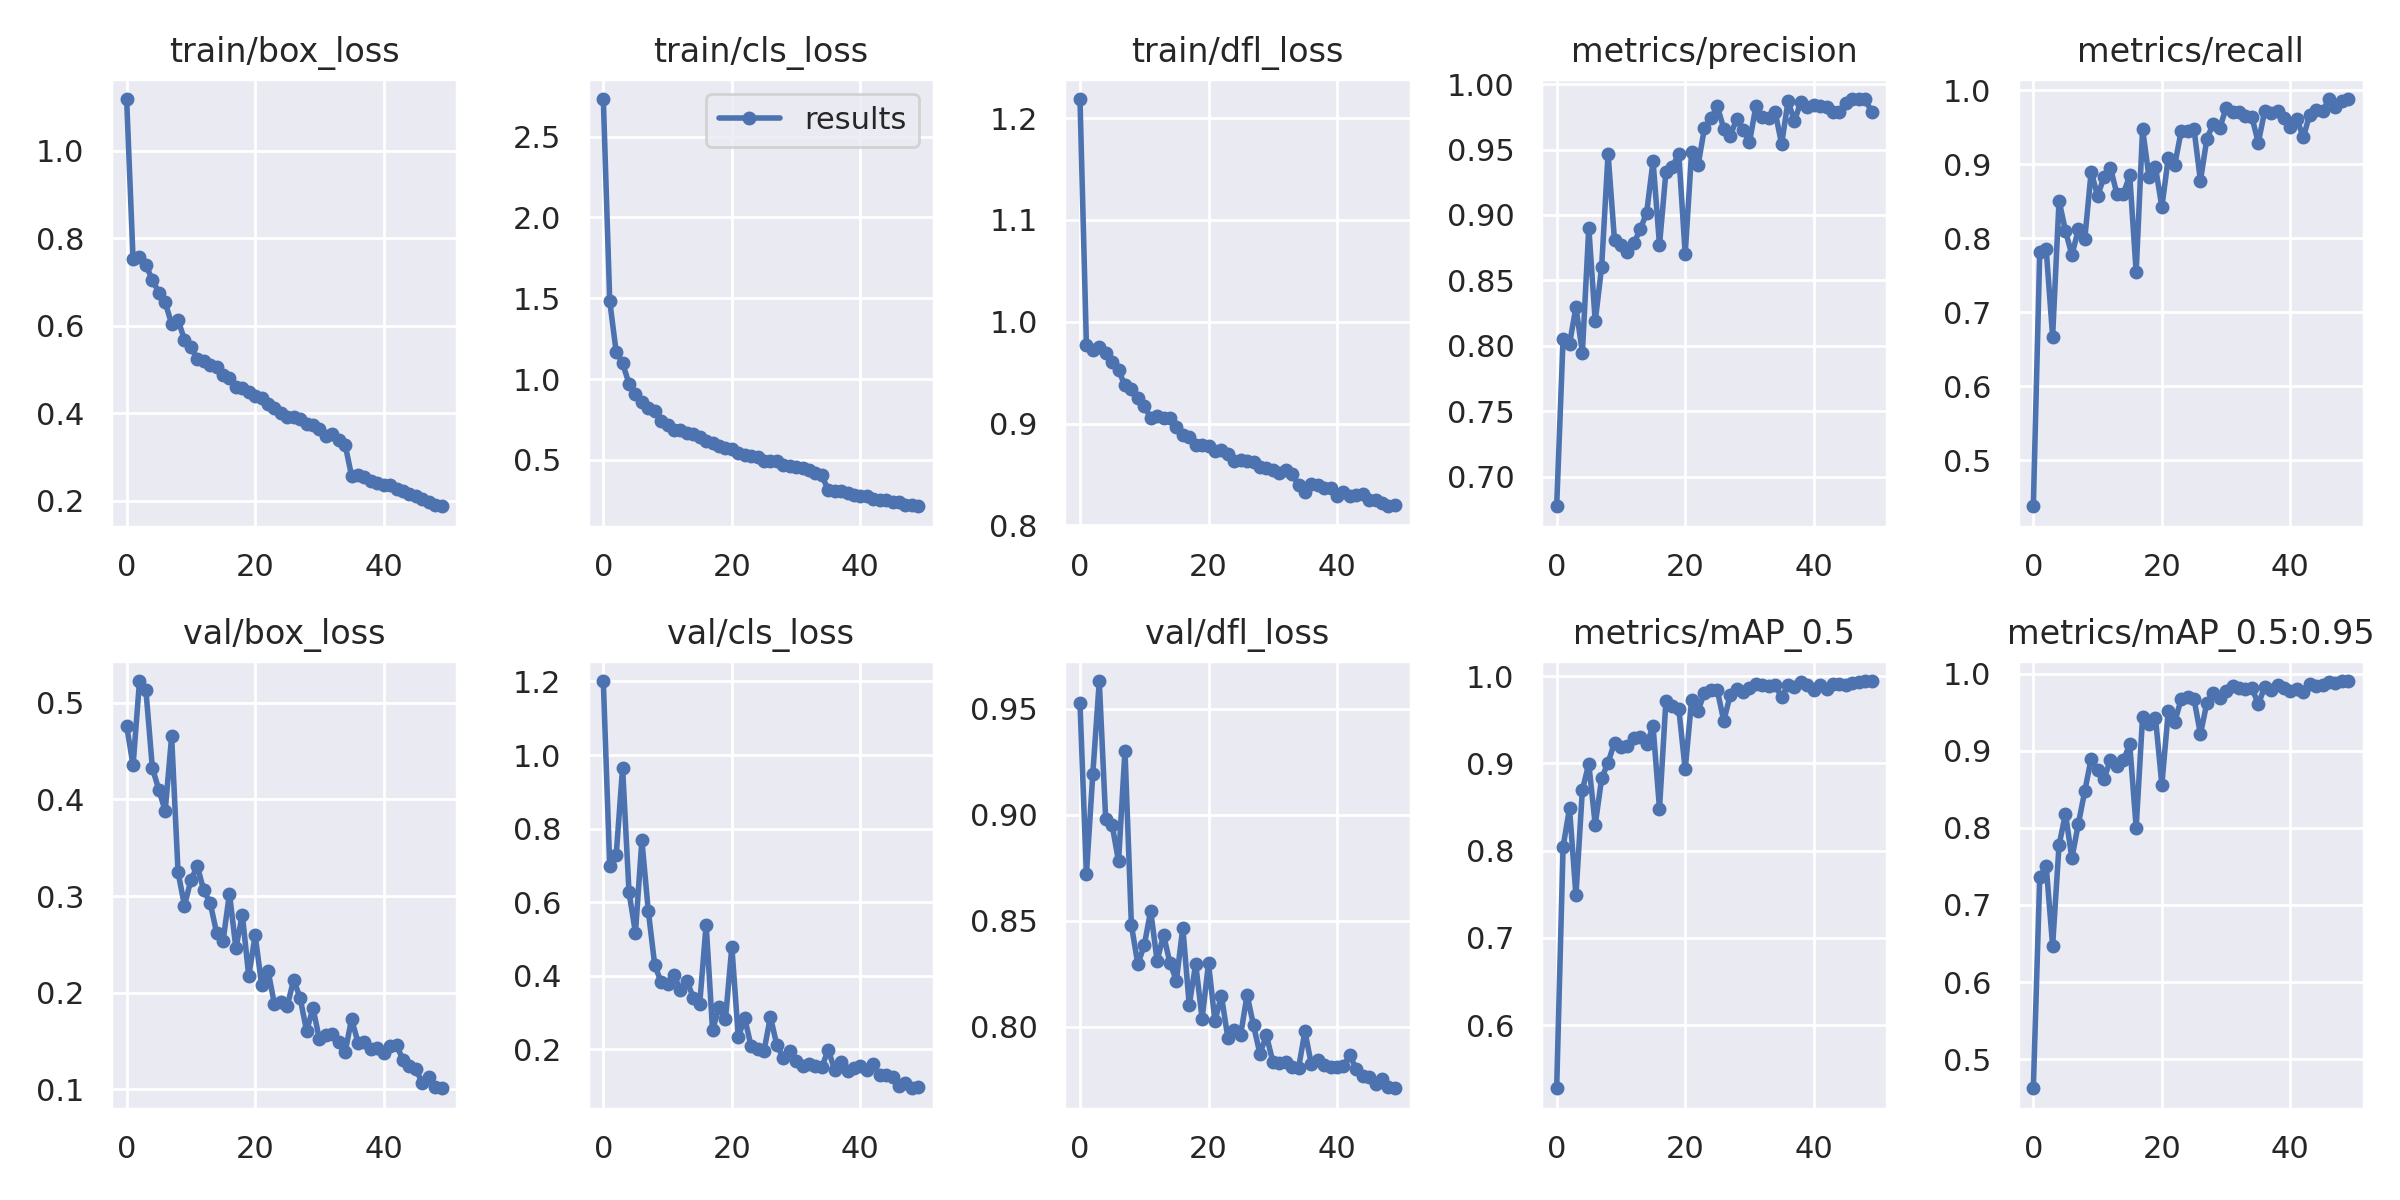

In [ ]:
from IPython.display import Image

Image(filename=f"{HOME}/yolov9/runs/train/exp/results.png", width=1000)

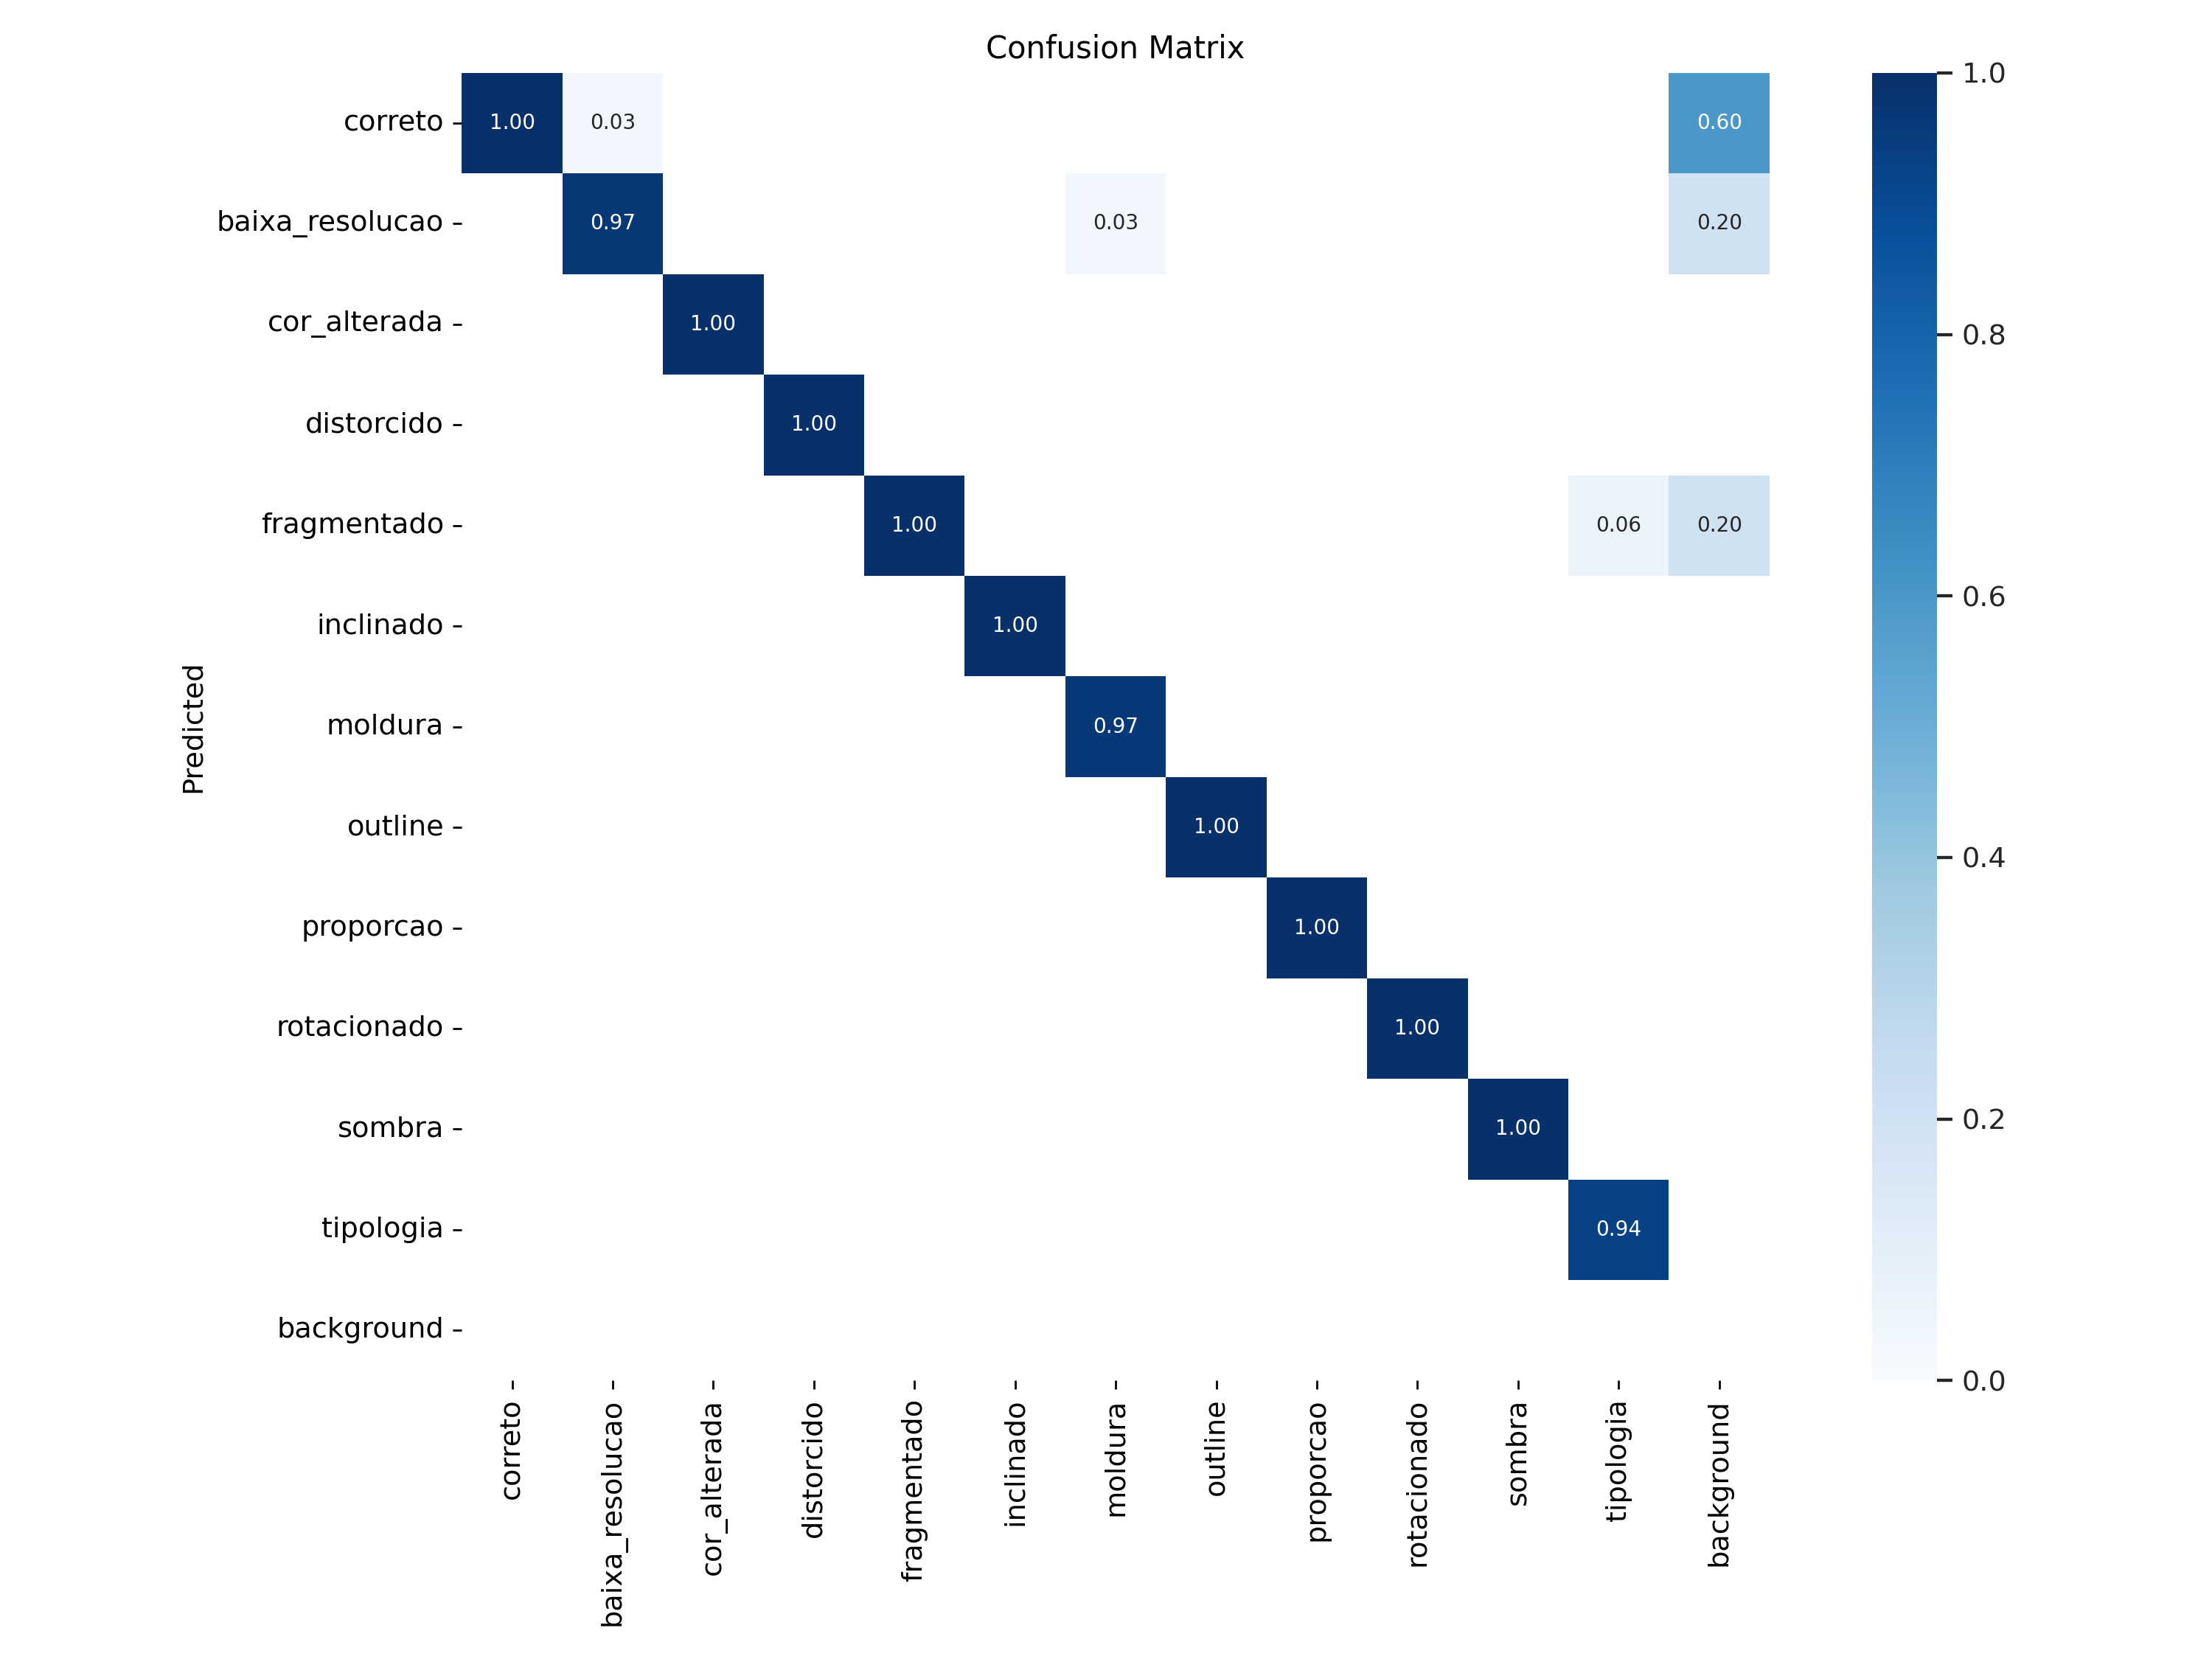

In [ ]:
from IPython.display import Image

Image(filename=f"{HOME}/yolov9/runs/train/exp/confusion_matrix.png", width=1000)

In [ ]:
%cd {HOME}/yolov9

!python val.py \
--img 640 --batch 32 --conf 0.001 --iou 0.7 --device 0 \
--data logos/data.yaml \
--weights {HOME}/yolov9/runs/train/exp/weights/best.pt

/content/drive/MyDrive/tcc_50/yolov9
val: data=logos/data.yaml, weights=['/content/drive/MyDrive/tcc_50/yolov9/runs/train/exp/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.7, max_det=300, task=val, device=0, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False, min_items=0
YOLOv5 🚀 1e33dbb Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

/content/drive/MyDrive/tcc_50/yolov9/models/experimental.py:75: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be f

In [ ]:
%cd {HOME}/yolov9

!python detect.py \
--img 1280 --conf 0.1 --device 0 \
--weights {HOME}/yolov9/runs/train/exp/weights/best.pt \
--source logos/test/images

python3: can't open file '/content/drive/MyDrive/tcc_50/detect.py': [Errno 2] No such file or directory


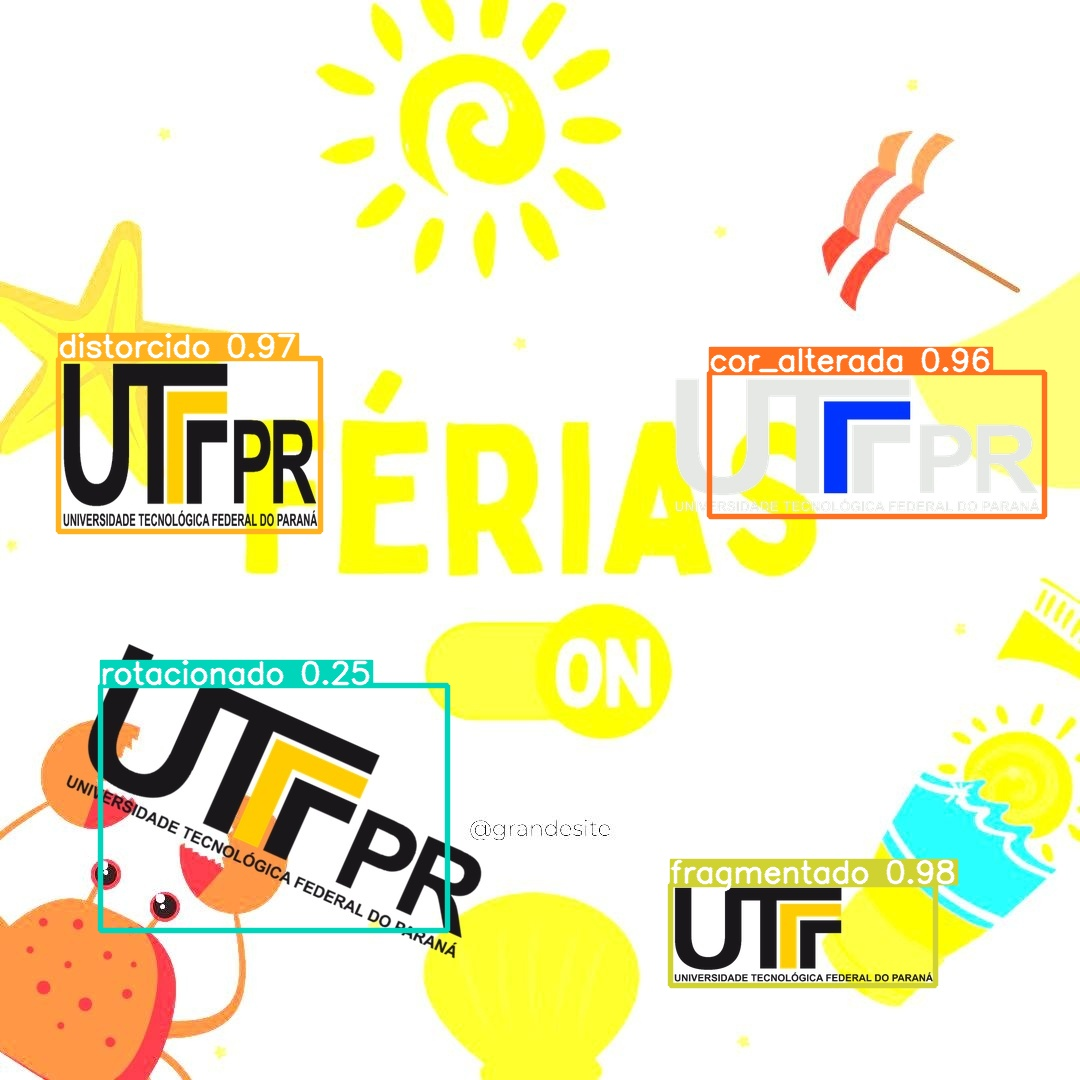

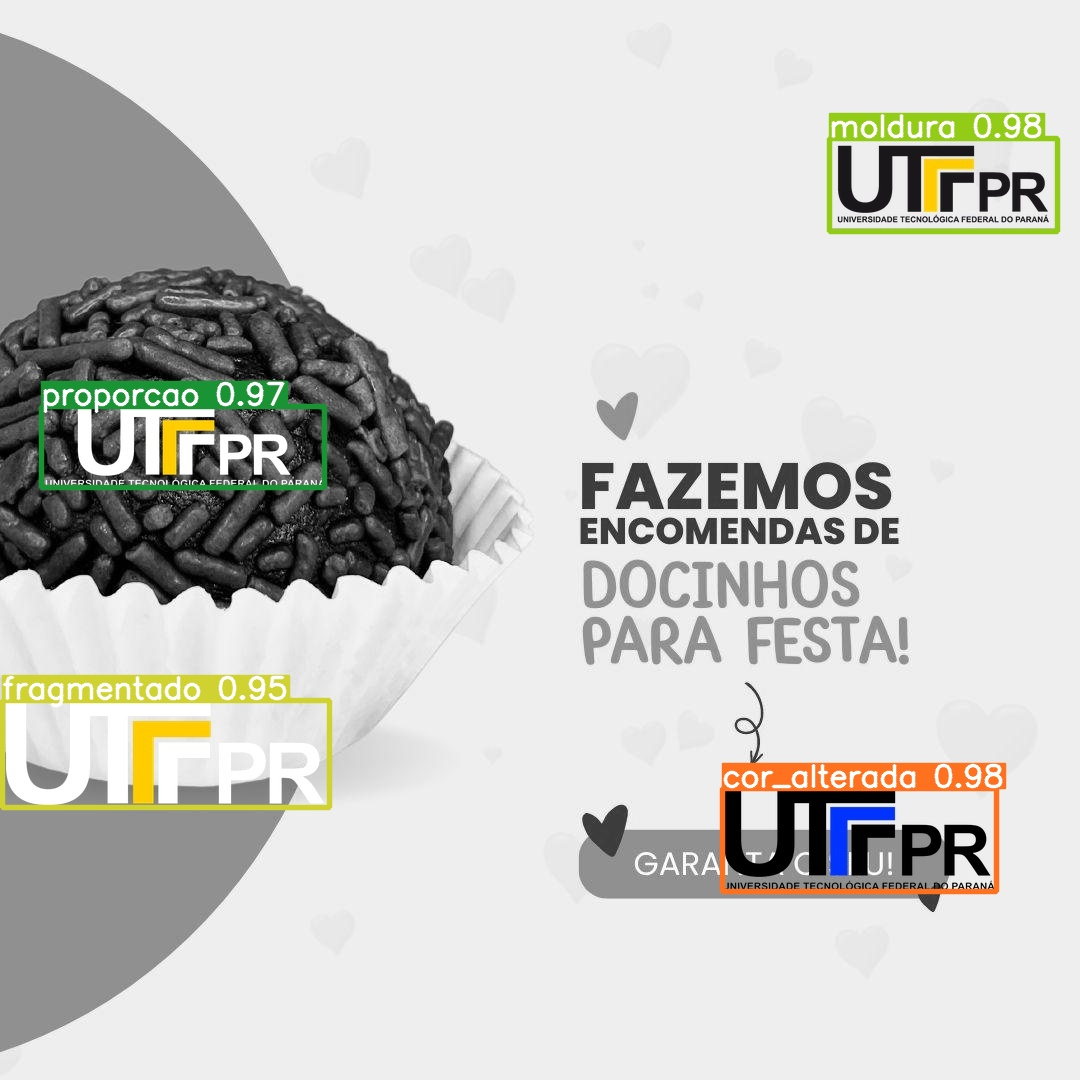

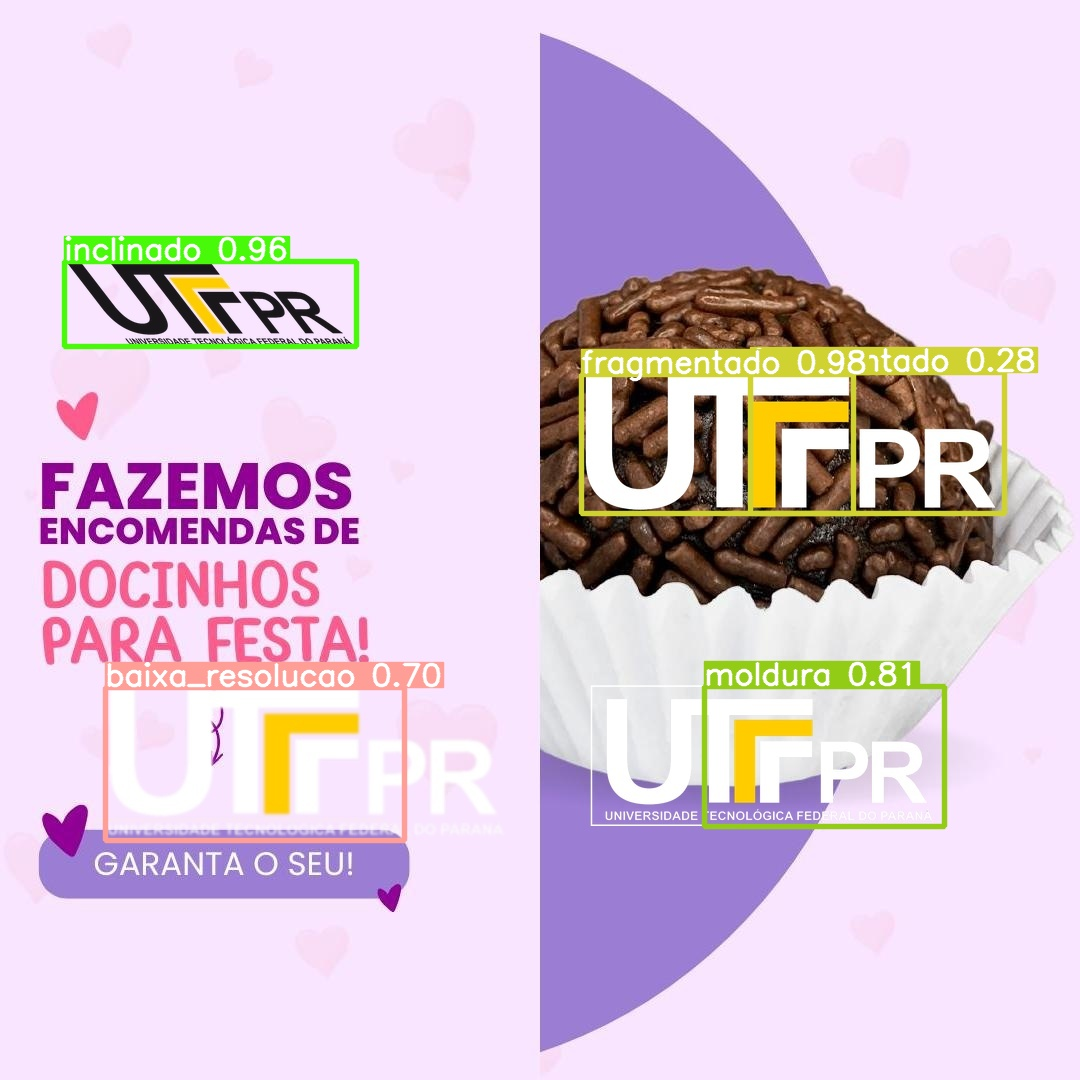

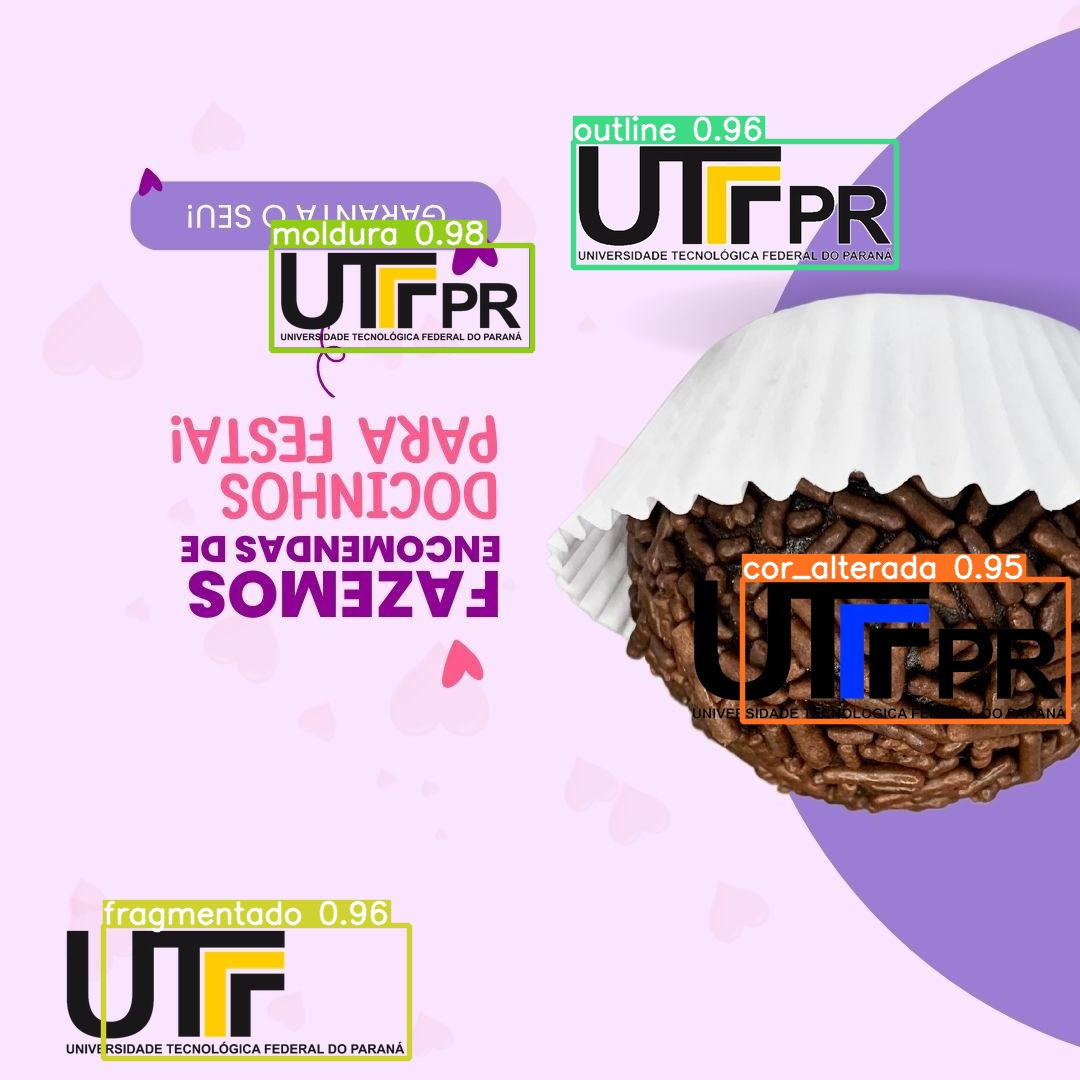

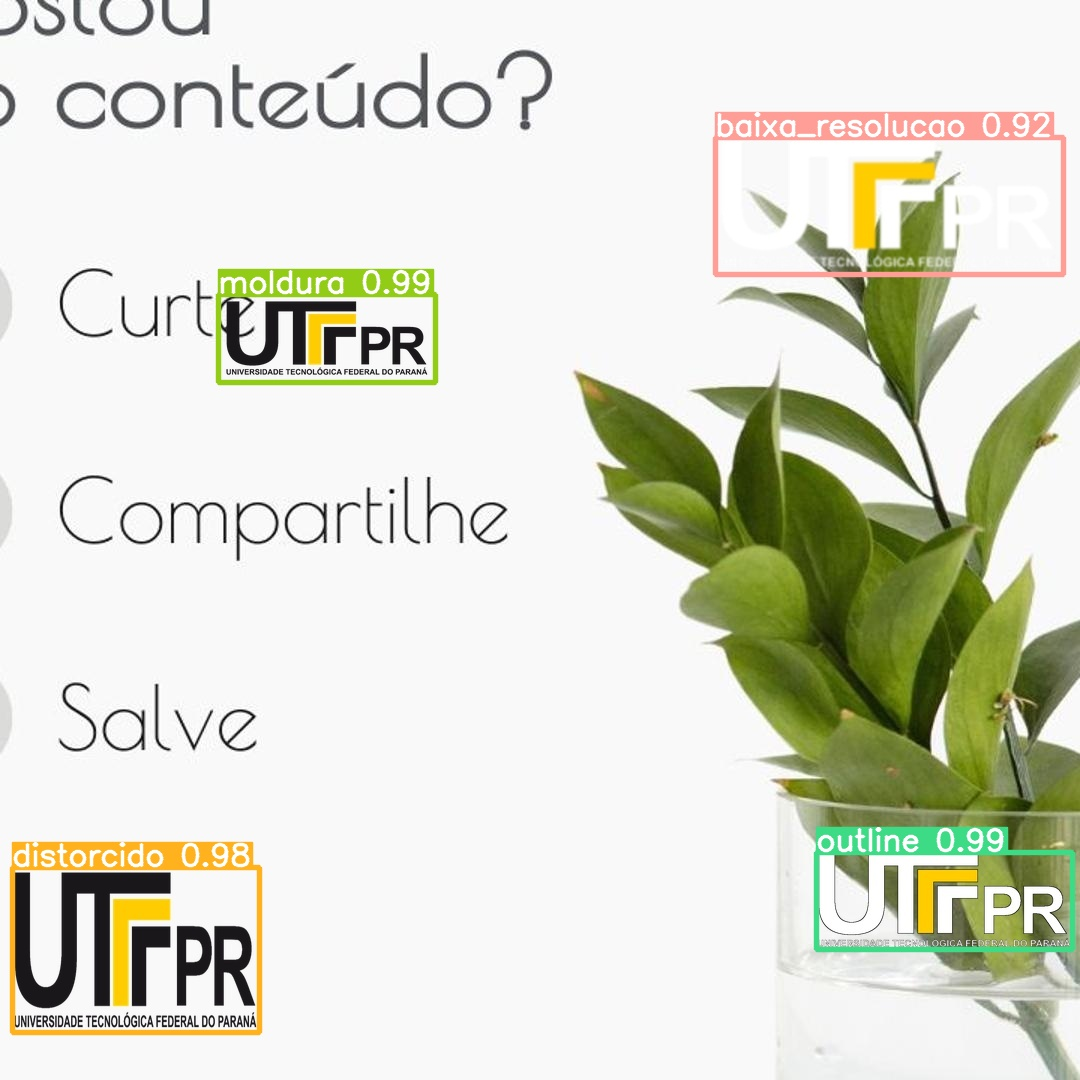

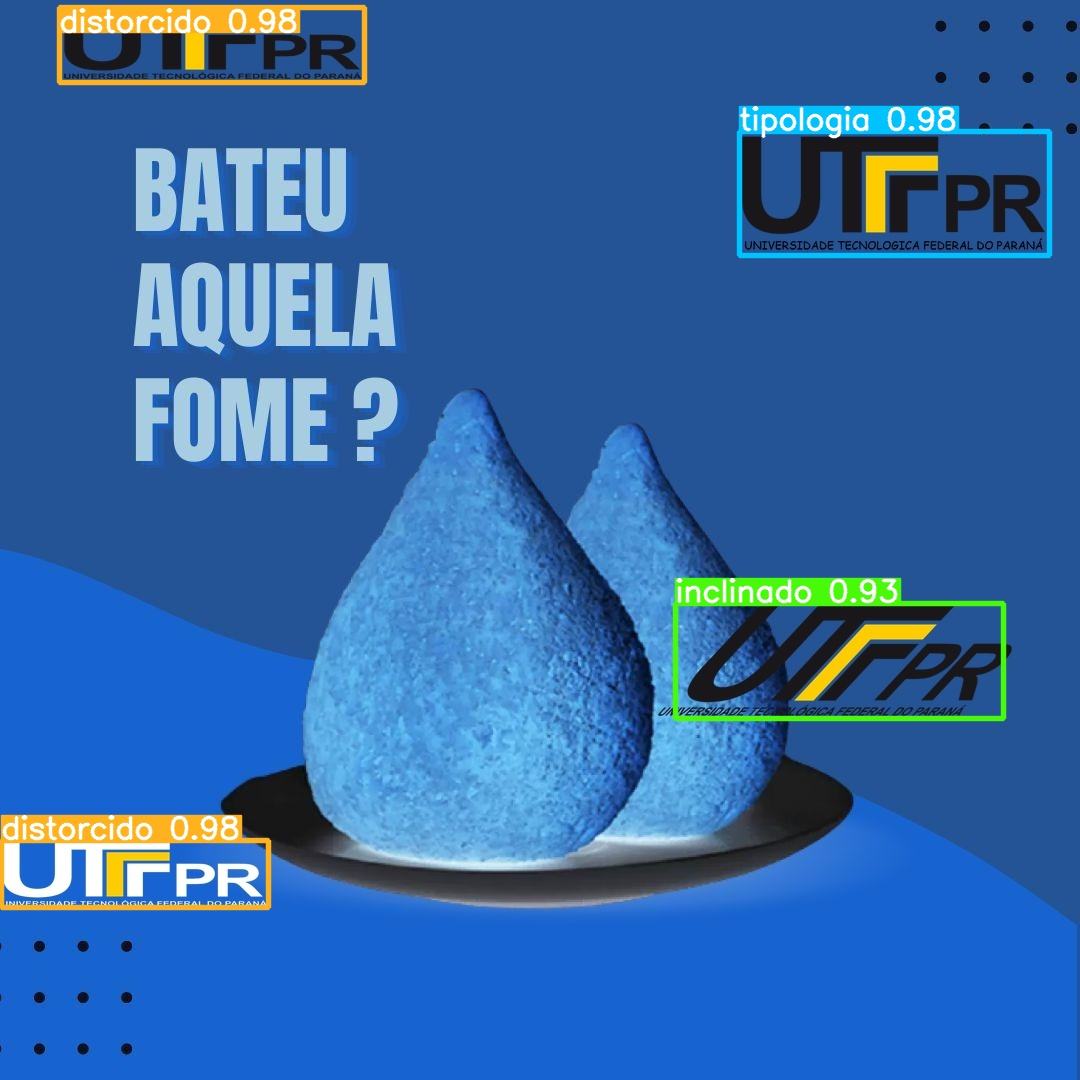

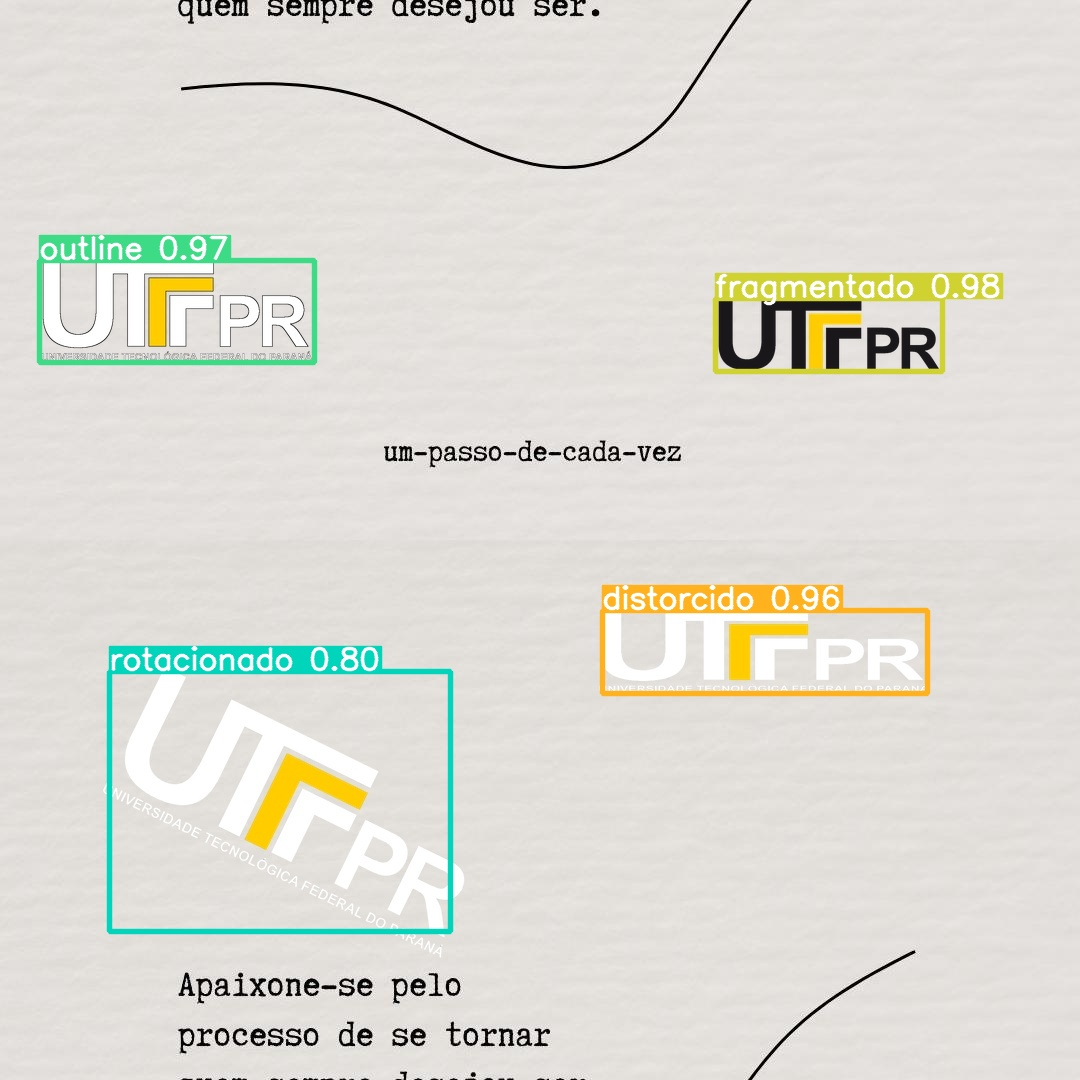

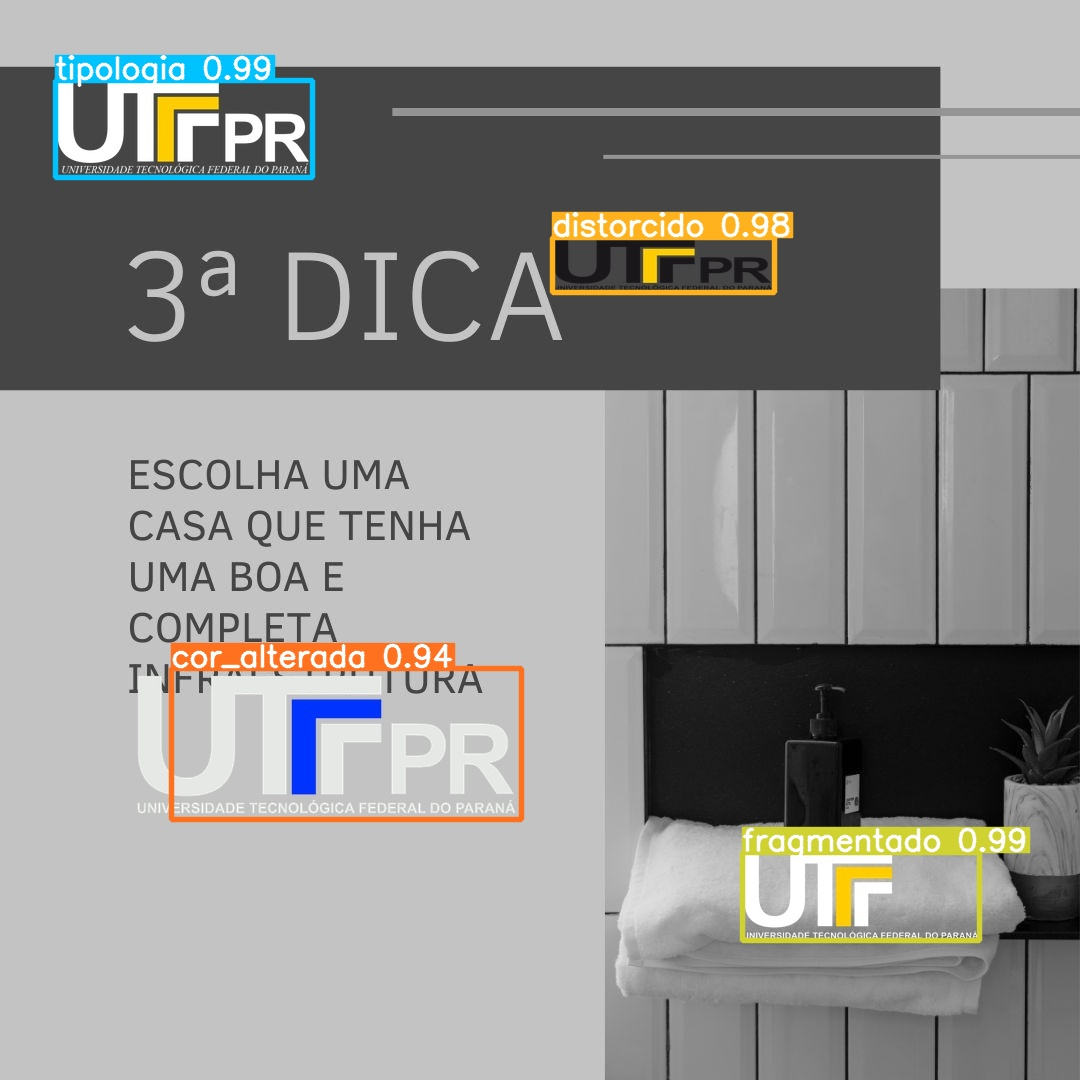

In [ ]:
import glob

from IPython.display import Image, display

for image_path in glob.glob(f'{HOME}/yolov9/runs/detect/exp/*.jpg')[:8]:
      display(Image(filename=image_path, width=600))

In [ ]:
%cd {HOME}/yolov9

!python detect.py \
--img 1280 --conf 0.1 --device 0 \
--weights {HOME}/yolov9/runs/train/exp/weights/best.pt \
--source ArtesLogoUTFPR

/content/drive/MyDrive/tcc_50/yolov9
detect: weights=['/content/drive/MyDrive/tcc_50/yolov9/runs/train/exp/weights/best.pt'], source=ArtesLogoUTFPR, data=data/coco128.yaml, imgsz=[1280, 1280], conf_thres=0.1, iou_thres=0.45, max_det=1000, device=0, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
requirements: YOLO requirement "ipython" not found, attempting AutoUpdate...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 26.9 MB/s eta 0:00:00

requirements: 1 package updated per /content/drive/MyDrive/tcc_50/yolov9/requirements.txt
requirements: ⚠️ Restart runtime or rerun command for updates to take effect

YOLOv5 🚀 1e33dbb Python-3.11.11 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

/content/drive/MyDrive/tcc_50/yolov9/models/experime